# Outline

- create a model that predicts the category of each article by Neural Network
- use `keras` and `scikeras` (wrapper for scikit-learn) to build a model
- train data is `matichon.json` that contains about 17K articles of Thai news by Matichon between 2015-2018
- X is `article`, using `CountVectorizer` and `TfidfVectorizer`
- unigram and bigram features
- y is category (10 labels)
- F1 score of Logistic Regression using articles with bigram features: **0.81**

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from cleanThaiText import tokenize ## custom tokenize function 

- custom tokenization function
- remove all quotations and shrink newlines `\n` and white spaces 

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [6]:
df = pd.read_json('data/matichon.json')

## drop "date", "url", and "id"
df.drop(columns=['date','url','id'], inplace=True)

df

,headline,article,category
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment
...,...,...,...
17104,โบว์ ณัฏฐา แจ้งความ พล.ต.อ.ศรีวราห์ ถูกพาดพิง...,เมื่อวันที่ 5 ก.ค. ที่ สน.พญาไท น.ส.ณัฏฐา มหัท...,politics
17105,ภาพบรรยากาศ ขุดทางระบายน้ำ เร่งนำ 13 ชีวิตออกจ...,วันที่ 5 กรกฎาคม เจ้าหน้าที่ขุดทางระบายน้ำที่ด...,region
17106,สนช.ผ่านพ.ร.บ.สงฆ์ 3 วาระรวด พระมหากษัตริย์ทรง...,"สนช.ผ่าน พ.ร.บ.สงฆ์ 3 วาระรวด ""วิษณุ"" แจงสาระส...",politics
17107,นานาทรรศนะเพิ่มค่าปรับหมอ 5ล้านบ. สกัดเบี้ยว...,หมายเหตุ – จากกรณีที่ กระทรวงศึกษาธิการ (ศธ.) ...,education


In [7]:
## value counts of target variable
df.category.value_counts()

category
politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: count, dtype: int64

# 1. Preprocessing

## tokenize

- input for Vectorizer must be a list of sentences (not list of tokens) 
- it may take more than 1 minute
- you can save the tokenized file by `df.to_json('XXX.json', orient='records', force_ascii=False)`

In [9]:
df['tokens'] = (df['headline'] + ' ' + df['article']).apply(lambda x: tokenize(x, return_list=False))
df.head()

,headline,article,category,tokens
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign,ซาอุฯ จ่อ เปิดไฟเขียว ให้ สิทธิ หญิง ม่าย หย่า...
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics,ไก่อู ชี้ ตู่ เต้น ไม่ ได้ มี หน้าที่ ตรวจสอบ ...
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment,เปิดใจ โบว์ แวนดา ระหว่าง รอ ยิ้ม ได้ เต็มที่ ...
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment,นาย ณ ภัทร ปลื้ม คน ชม แชมป์ ขึ้น ปก นิตยสาร แ...
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment,คอ แทบ หัก แม่ยก แห่ คล้อง พวงมาลัย ักษ์ บอย ศ...


## define `X`, `y` and train-test splitting


In [10]:
X = df['tokens']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Modelling

## define NN model

In [11]:
def create_NN(meta={}):
    ## used in scikeras wrapper
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]

    ## Instantiate Model with 2 hidden layers
    model = Sequential()
    model.add(Dense(n_features_in_, input_shape=X_shape_[1:])) # input layer
    model.add(Dense(128, activation='relu', name=f'Hidden1')) # 1st hidden layer
    model.add(Dropout(0.2, name=f'Dropout1')) 
    model.add(Dense(64, activation='relu', name=f'Hidden2')) # 2nd hidden layer
    model.add(Dropout(0.2, name=f'Dropout2')) 
    model.add(Dense(n_classes_, activation='softmax', name='Output')) # output layer
    return model

## make pipelines

- `Vectorizer` returns sparse matrix but NN accepts only dense matrix
- so, one more transformer is necessary between those two - `FunctionTransformer`

In [12]:
# instantiate vectorizers
# use only 5000 features (if more, it takes too much time)
cvec = CountVectorizer(min_df=3, max_df=0.5, max_features=10000, ngram_range=(1,2))
tvec = TfidfVectorizer(min_df=3, max_df=0.5, max_features=10000, ngram_range=(1,2))

# instantiate NN estimators
NN_cvec = KerasClassifier(create_NN, loss='sparse_categorical_crossentropy', epochs=3, metrics='accuracy', validation_split=0.2)
NN_tvec = KerasClassifier(create_NN, loss='sparse_categorical_crossentropy', epochs=3, metrics='accuracy', validation_split=0.2)

# pipelines
pipe_cvec = Pipeline([('cvec', cvec), ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), ('NN_cvec', NN_cvec)])
pipe_tvec = Pipeline([('tvec', tvec), ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), ('NN_tvec', NN_tvec)])

## fit

- loss is decreasing, but validation loss is increasing gradually = overfitting
- epoch 1-2 may be enough

In [13]:
print("--- Count Vectorizer ---")
pipe_cvec.fit(X_train, y_train)

print("\n--- TFIDF Vectorizer ---")
pipe_tvec.fit(X_train, y_train)

--- Count Vectorizer ---
Epoch 1/3
343/343 [==============================] - 128s 373ms/step - loss: 1.7283 - accuracy: 0.5739 - val_loss: 1.0911 - val_accuracy: 0.6914
Epoch 2/3
343/343 [==============================] - 132s 385ms/step - loss: 1.2777 - accuracy: 0.6832 - val_loss: 1.2810 - val_accuracy: 0.6939
Epoch 3/3
343/343 [==============================] - 126s 367ms/step - loss: 1.0817 - accuracy: 0.7426 - val_loss: 1.3462 - val_accuracy: 0.7465

--- TFIDF Vectorizer ---
Epoch 1/3
343/343 [==============================] - 127s 370ms/step - loss: 0.8634 - accuracy: 0.7160 - val_loss: 0.7082 - val_accuracy: 0.7787
Epoch 2/3
343/343 [==============================] - 126s 368ms/step - loss: 0.4666 - accuracy: 0.8470 - val_loss: 0.7430 - val_accuracy: 0.7831
Epoch 3/3
343/343 [==============================] - 132s 383ms/step - loss: 0.2972 - accuracy: 0.9002 - val_loss: 0.9048 - val_accuracy: 0.7655


Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.5, max_features=10000, min_df=3,
                                 ngram_range=(1, 2))),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x2a03e2700>)),
                ('NN_tvec',
                 KerasClassifier(epochs=3, loss='sparse_categorical_crossentropy', metrics='accuracy', model=<function create_NN at 0x2d5a085e0>, validation_split=0.2))])

## predict and evaluate


In [16]:
pred_cvec = pipe_cvec.predict(X_test)
pred_tvec = pipe_tvec.predict(X_test)

107/107 [==============================] - 3s 26ms/step


### count vectorizer

               precision    recall  f1-score   support

        crime       0.60      0.76      0.67       428
      economy       0.81      0.63      0.71       250
    education       0.74      0.71      0.72       211
entertainment       0.94      0.90      0.92       185
      foreign       0.92      0.89      0.91       266
        local       0.38      0.31      0.35       388
     politics       0.89      0.80      0.84       627
    publicize       0.82      0.76      0.79       296
       region       0.57      0.74      0.65       531
        sport       0.98      0.84      0.90       240

     accuracy                           0.72      3422
    macro avg       0.77      0.73      0.75      3422
 weighted avg       0.74      0.72      0.73      3422



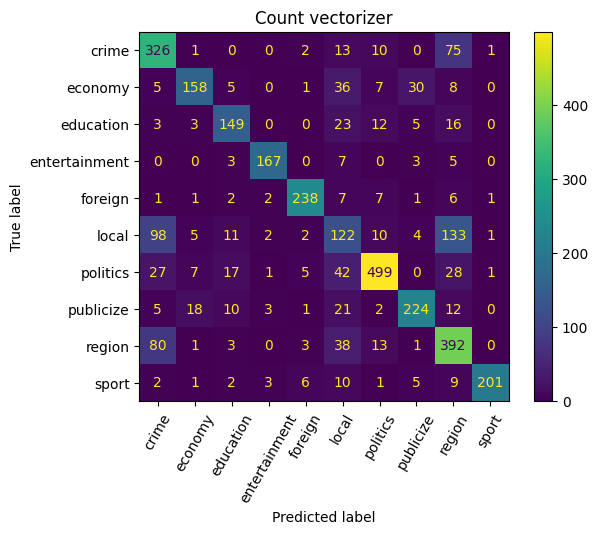

In [17]:
## print F1 scores
print(classification_report(y_test, pred_cvec))

## confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_cvec), display_labels=pipe_cvec.classes_)
disp.plot(xticks_rotation=60)
plt.title('Count vectorizer');

### TFIDF vectorizer

               precision    recall  f1-score   support

        crime       0.56      0.81      0.66       428
      economy       0.70      0.77      0.74       250
    education       0.72      0.79      0.75       211
entertainment       0.93      0.88      0.90       185
      foreign       0.92      0.92      0.92       266
        local       0.47      0.40      0.43       388
     politics       0.88      0.82      0.85       627
    publicize       0.82      0.76      0.79       296
       region       0.68      0.55      0.61       531
        sport       0.95      0.94      0.94       240

     accuracy                           0.74      3422
    macro avg       0.76      0.76      0.76      3422
 weighted avg       0.74      0.74      0.74      3422



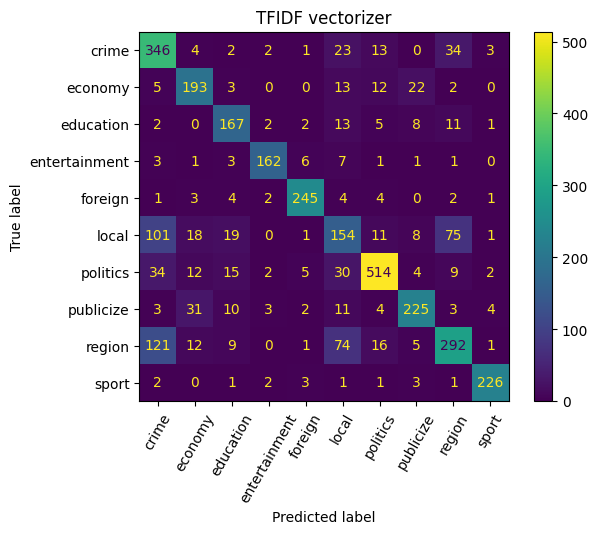

In [18]:
## print F1 scores
print(classification_report(y_test, pred_tvec))

## confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_tvec), display_labels=pipe_tvec.classes_)
disp.plot(xticks_rotation=60)
plt.title('TFIDF vectorizer');

### model comparison

![cm_count_tfidf](image/cm_count_tfidf.png)

# Result Summary


- the accuracy and F1 are lower than Part.1
- must tune hyperparameters (e.g. max features, number of hidden layers), but time-spending
- TFIDF is better a little between the two vectorizers, but confusion matrix shows a different pattern of misprediction